In [1]:
!pip install efficientnet

In [2]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
epochs = 2
dropout_rate = 0.2
input_shape = (224, 224, 3)
train_dir = '/content/drive/My Drive/datasets/UcClass/train'
validation_dir = '/content/drive/My Drive/datasets/UcClass/val'

In [0]:
from efficientnet.tfkeras import EfficientNetB0 as Net
from efficientnet.tfkeras import center_crop_and_resize, preprocess_input

In [6]:
conv_base = Net(weights='imagenet', include_top=False, input_shape=input_shape)

16809984/16804768 [==============================] - 1s 0us/step


In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        batch_size=32,
        # All images will be resized to target height and width.
        target_size=(224, 224),
        # Since we use categorical_crossentropy loss, we need categorical labels
        class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical')

Found 4640 images belonging to 3 classes.
Found 1163 images belonging to 3 classes.


In [0]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.GlobalMaxPooling2D(name="gap"))
# model.add(layers.Flatten(name="flatten"))
if dropout_rate > 0:
    model.add(layers.Dropout(dropout_rate, name="dropout_out"))
model.add(layers.Dense(256, activation='relu', name="fc1"))
model.add(layers.Dense(3, activation='softmax', name="fc_out"))

In [0]:
#bu kod ile multiply adlı layera kadar eğitilemez sonrası eğitilebilir oldu
set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'multiply_16':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b0 (Model)      (None, 7, 7, 1280)        4049564   
_________________________________________________________________
gap (GlobalMaxPooling2D)     (None, 1280)              0         
_________________________________________________________________
dropout_out (Dropout)        (None, 1280)              0         
_________________________________________________________________
fc1 (Dense)                  (None, 256)               327936    
_________________________________________________________________
fc_out (Dense)               (None, 3)                 771       
Total params: 4,378,271
Trainable params: 328,707
Non-trainable params: 4,049,564
_________________________________________________________________


Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/2
145/145 [==============================] - 2115s 15s/step - loss: 1.5644 - acc: 0.5810 - val_loss: 0.3842 - val_acc: 0.8785
Epoch 2/2
145/145 [==============================] - 459s 3s/step - loss: 0.6154 - acc: 0.8093 - val_loss: 0.2842 - val_acc: 0.9253


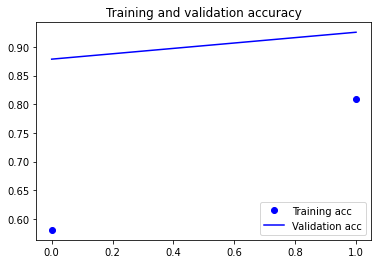

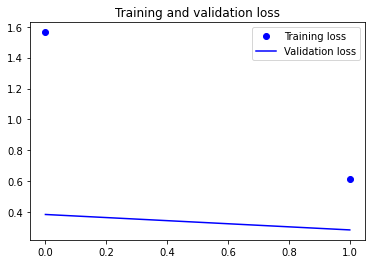

In [11]:
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])
history = model.fit_generator(
      train_generator,
      steps_per_epoch= train_generator.n//train_generator.batch_size,
      epochs=epochs,
      validation_data=validation_generator,
      validation_steps= validation_generator.n//validation_generator.batch_size)

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_x = range(len(acc))

plt.plot(epochs_x, acc, 'bo', label='Training acc')
plt.plot(epochs_x, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs_x, loss, 'bo', label='Training loss')
plt.plot(epochs_x, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()